In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from aefc_vortex.math_module import xp, xcipy, ensure_np_array
from aefc_vortex import utils
from aefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from aefc_vortex import dm
from aefc_vortex import props
from aefc_vortex import aefc_2dm as aefc
import aefc_vortex.fresnel_2dm_96 as fresnel
import aefc_vortex.fraunhofer_2dm_96 as fraunhofer




/home/kianmilani/Projects/adefc-vortex/aefc_vortex


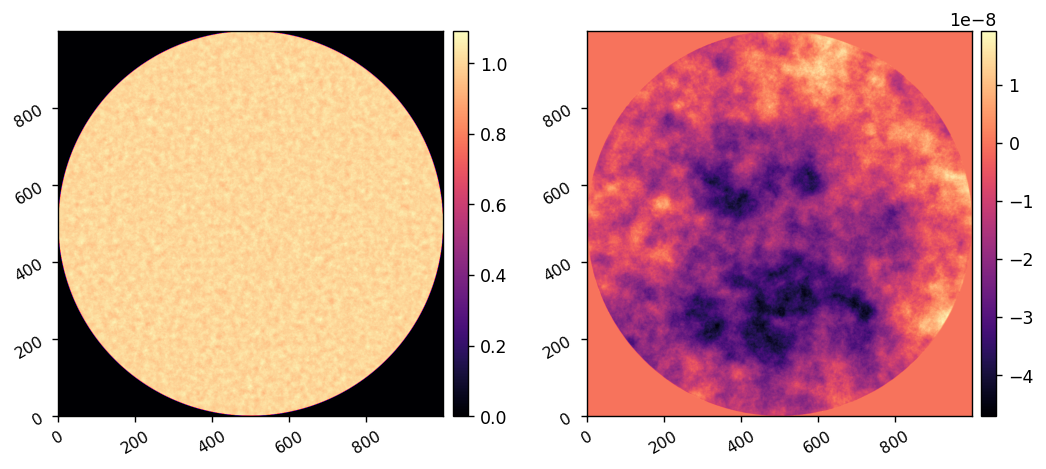

In [3]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/adefc-vortex/aefc_vortex


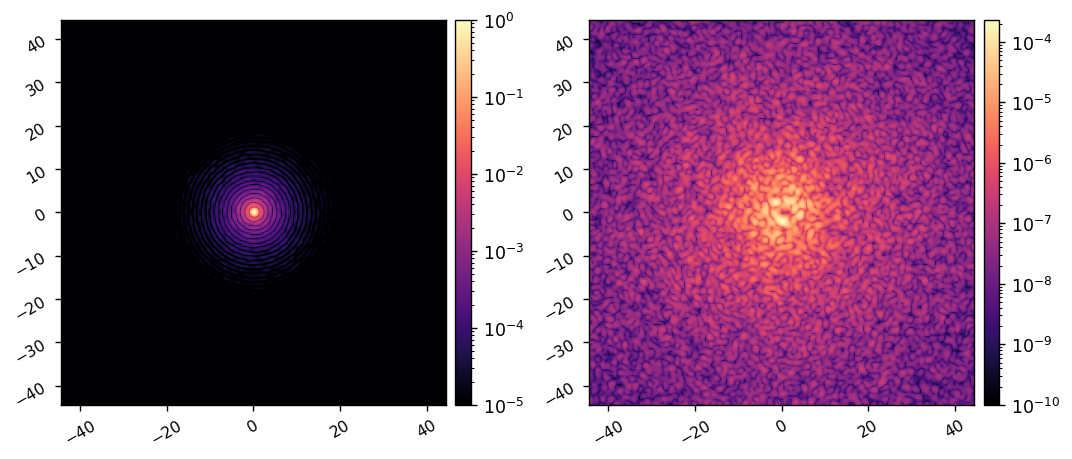

In [4]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


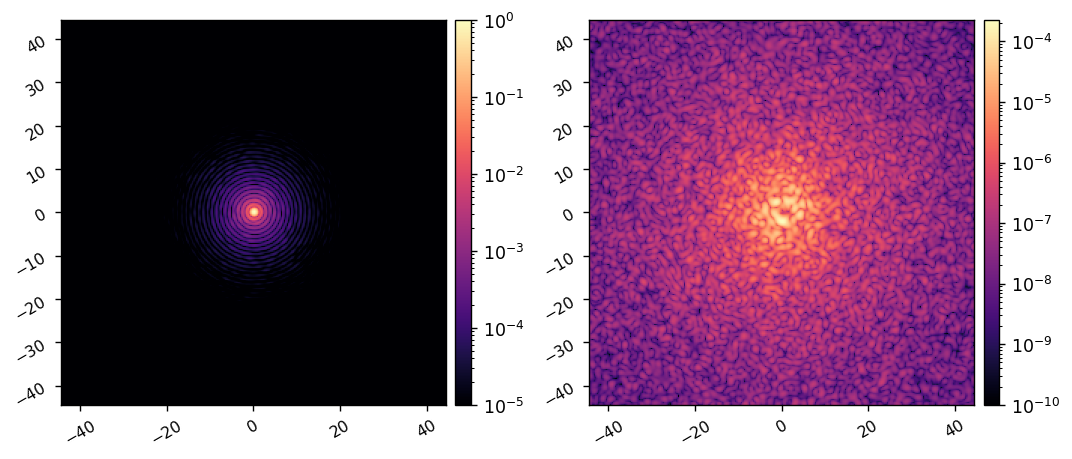

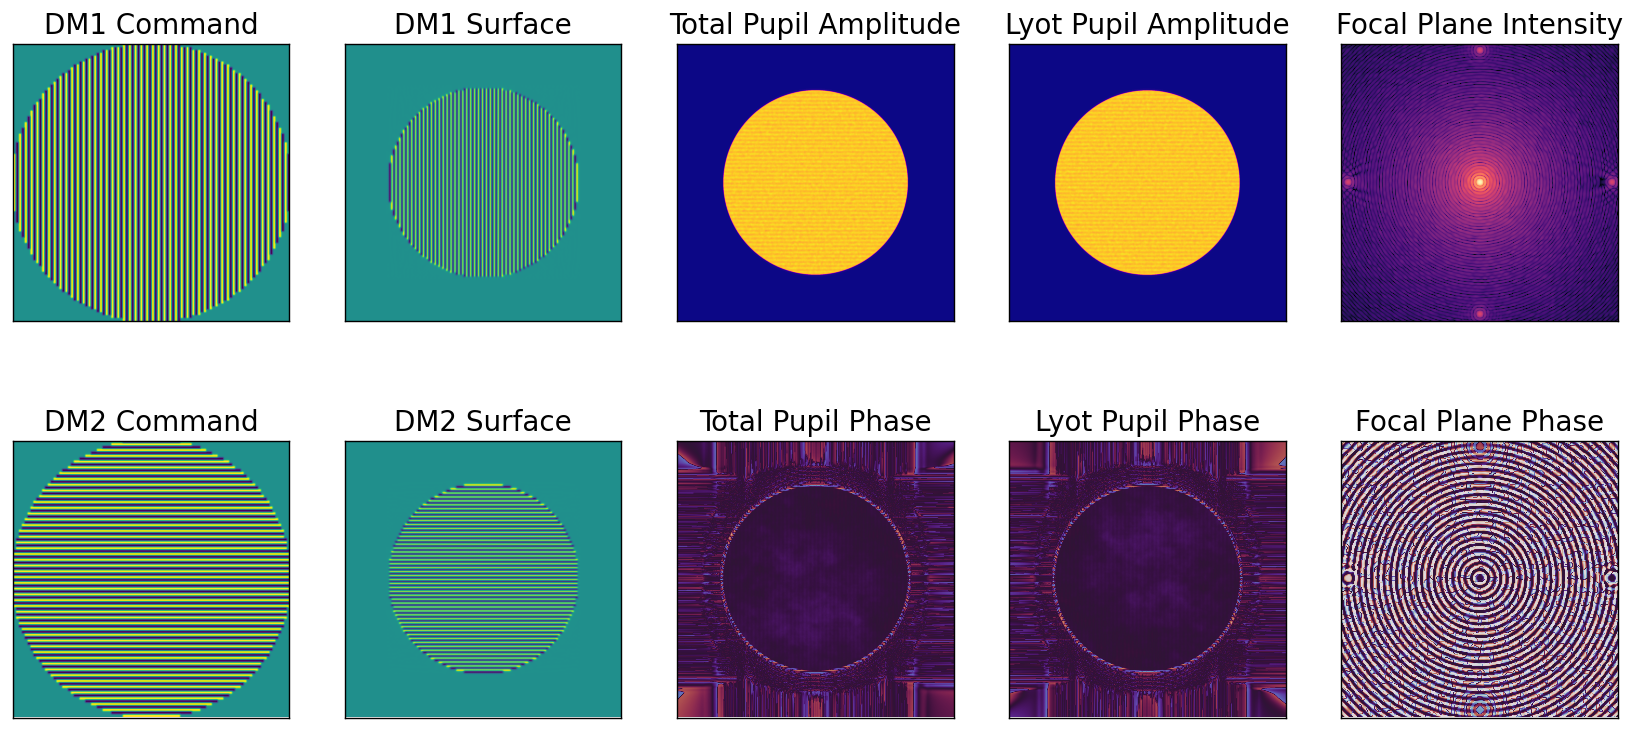

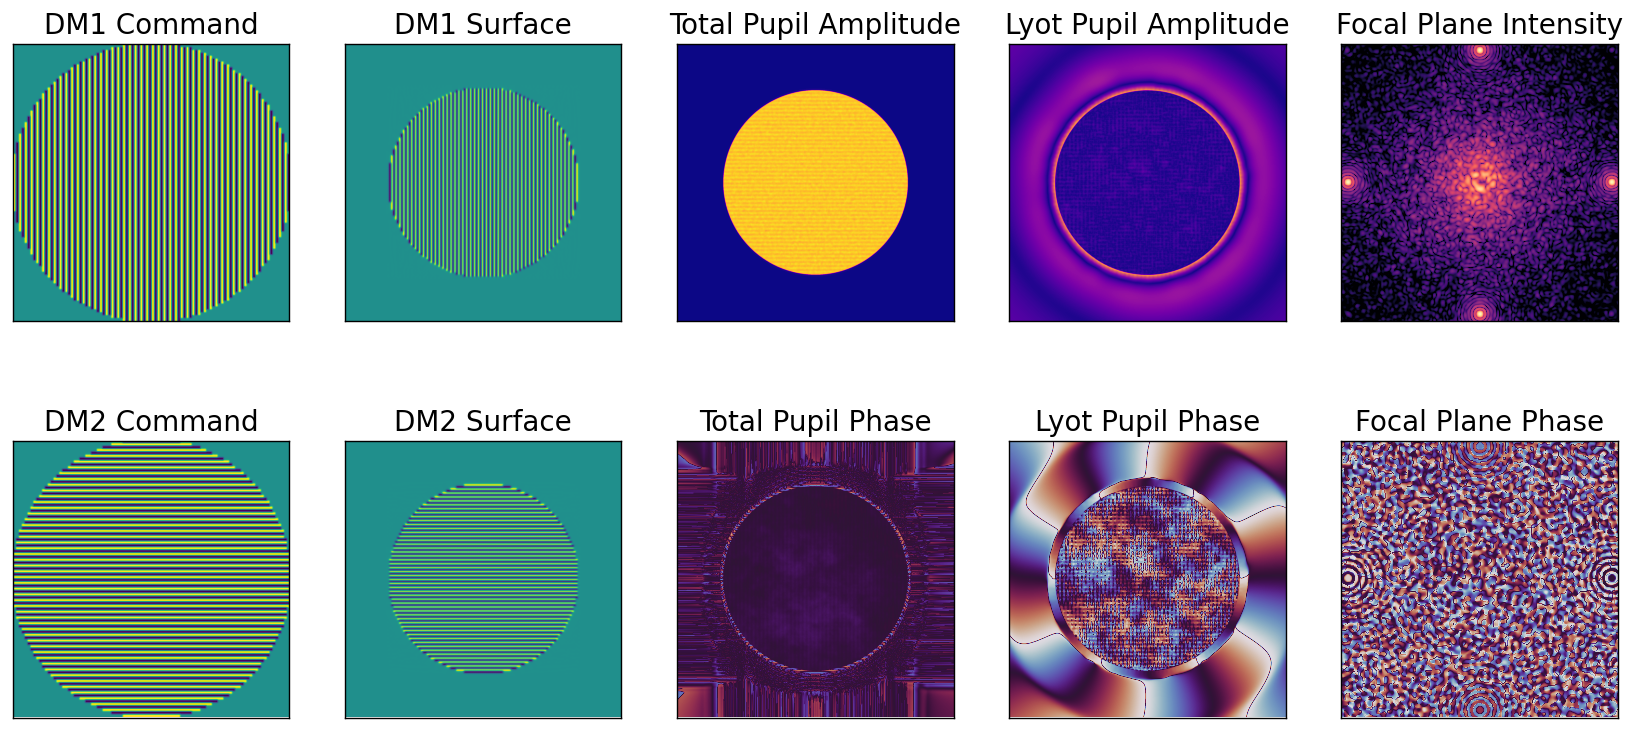

In [5]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )
dm1_command = 2.5e-9*utils.make_fourier_command(x_cpa=48, y_cpa=0, Nact=96)
dm2_command = 2.5e-9*utils.make_fourier_command(x_cpa=0, y_cpa=48, Nact=96)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf = M.forward(acts, M.wavelength_c, use_vortex=0, fancy_plot=1)
fpwf = M.forward(acts, M.wavelength_c, use_vortex=1, fancy_plot=1)

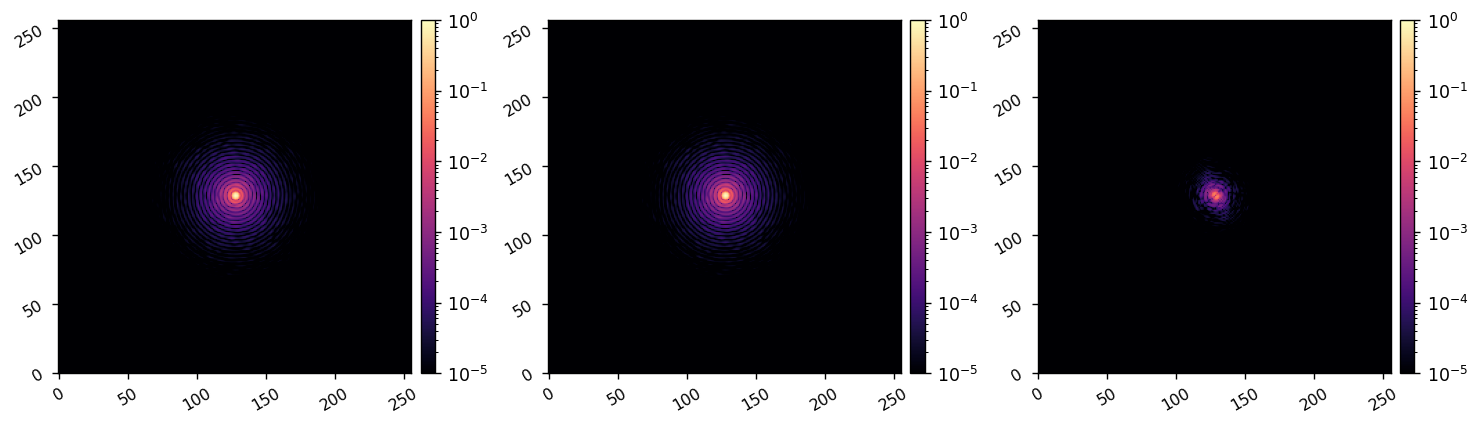

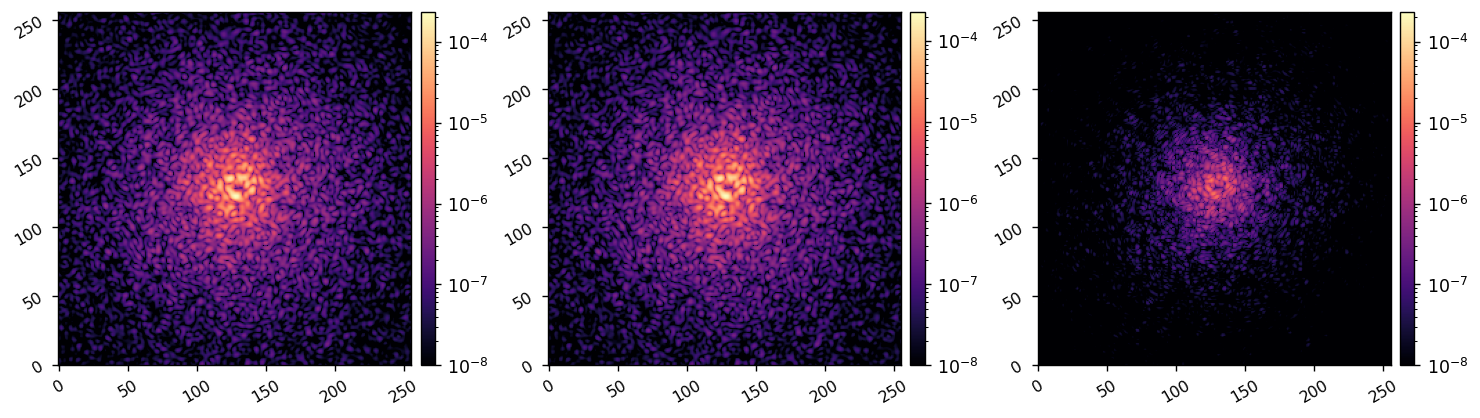

In [6]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

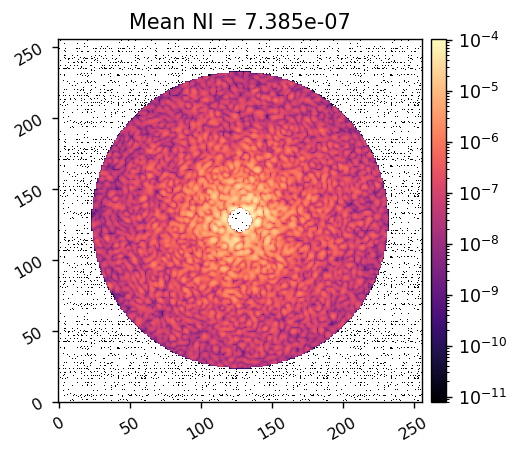

In [8]:
reload(utils)
I.zero_dms()
iwa = 3
owa = 36
rot = 0
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)


	Cost-function J_delE: 0.025
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.025
	Total cost-function value: 1.000



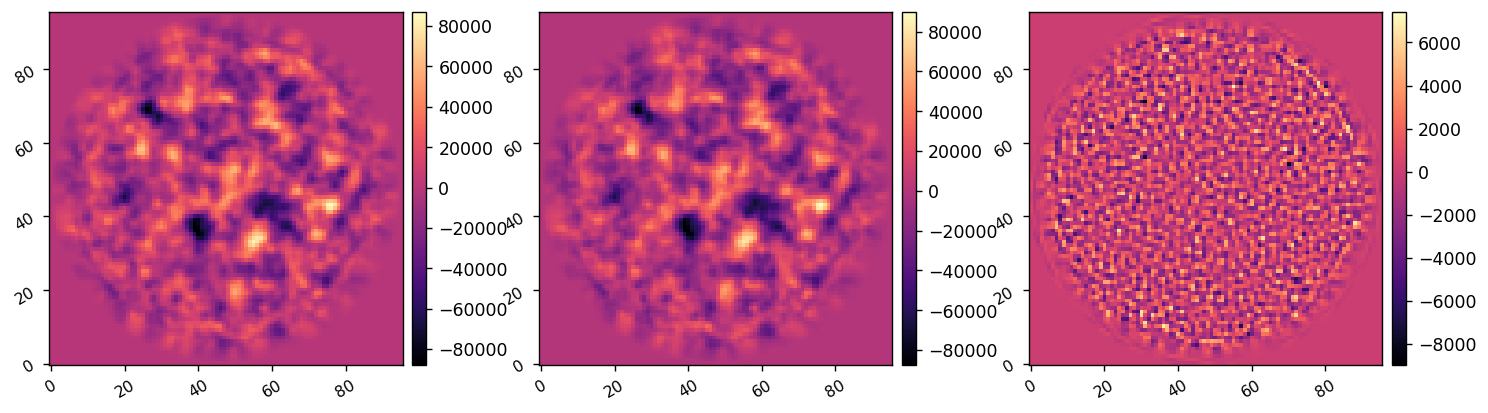

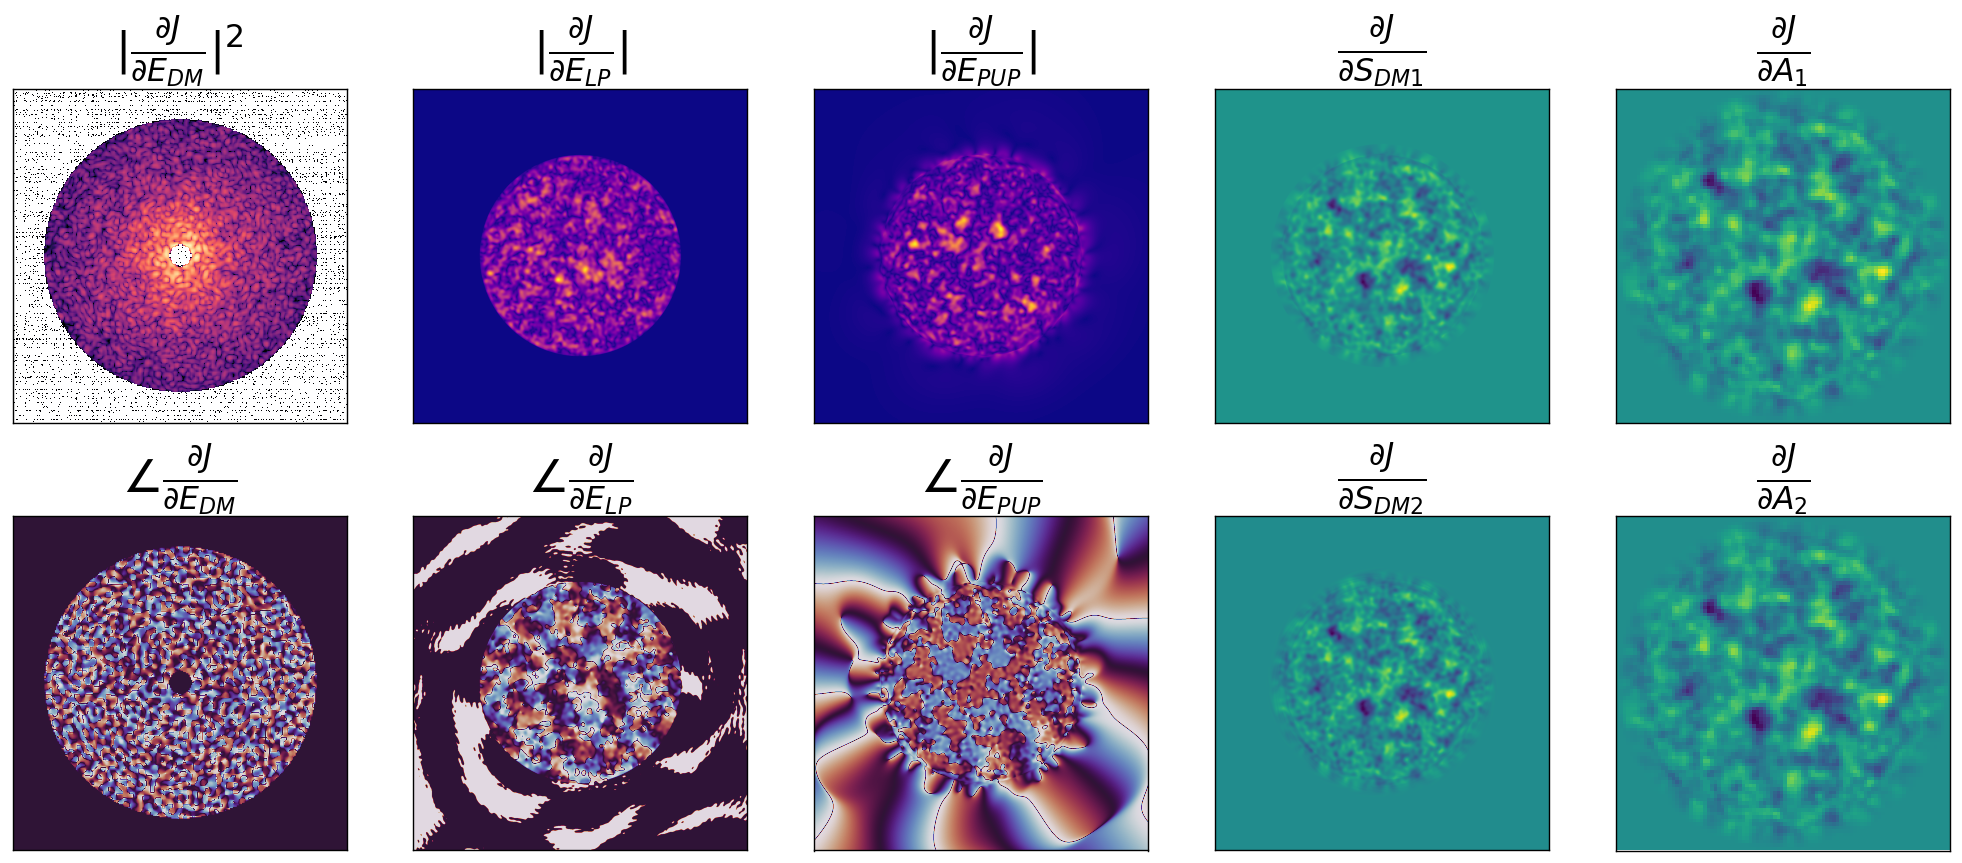

In [10]:
reload(fraunhofer)
current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask

E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_NOM':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad(
    del_acts, 
    M, 
    rmad_vars,
    verbose=True, 
    # plot=True, 
    fancy_plot=True,
)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

In [11]:
reload(fraunhofer)

current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask
E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_NOM':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(
    fraunhofer.val_and_grad, 
    jac=True, 
    x0=del_acts0,
    args=(M, rmad_vars, True, False), 
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=bfgs_opts,
)


	Cost-function J_delE: 0.025
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.025
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14736     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  8.97529D+04
	Cost-function J_delE: 0.051
	Cost-function J_c: 2366863905.325
	Cost-function normalization factor: 0.025
	Total cost-function value: 95465690217.714



 This problem is unconstrained.


	Cost-function J_delE: 8.795
	Cost-function J_c: 0.038
	Cost-function normalization factor: 0.025
	Total cost-function value: 356.260

	Cost-function J_delE: 0.017
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.025
	Total cost-function value: 0.681


At iterate    1    f=  6.80723D-01    |proj g|=  6.95431D+04
	Cost-function J_delE: 0.002
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.025
	Total cost-function value: 0.100


At iterate    2    f=  1.00269D-01    |proj g|=  1.20455D+04
	Cost-function J_delE: 0.002
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.025
	Total cost-function value: 0.075


At iterate    3    f=  7.54476D-02    |proj g|=  8.10406D+03
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.025
	Total cost-function value: 0.051


At iterate    4    f=  5.13878D-02    |proj g|=  4.77525D+03
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization f

7.384970340267022e-07 9.743047543642613e-09


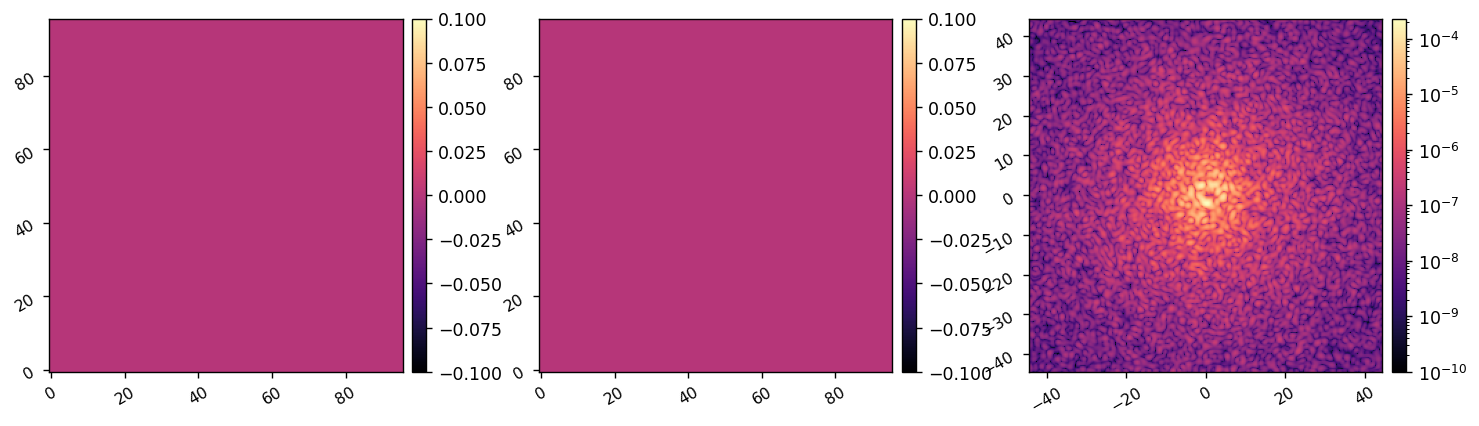

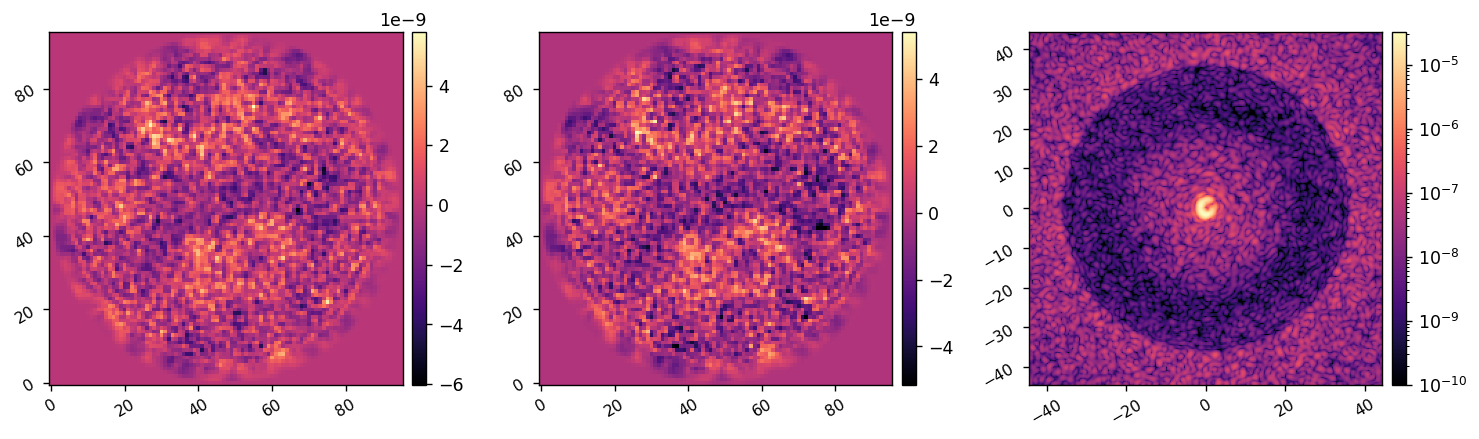

In [12]:
old_dm1 = fraunhofer.acts_to_command(current_acts[:M.Nacts//2], I.dm_mask)
old_dm2 = fraunhofer.acts_to_command(current_acts[M.Nacts//2:], I.dm_mask)
del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.set_dm1(old_dm1)
I.set_dm2(old_dm2)
old_im = I.snap()

I.set_dm1(old_dm1 + del_dm1)
I.set_dm2(old_dm2 + del_dm2)
new_im = I.snap()

print(xp.mean(old_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, old_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [18]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [13]:
I.zero_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Computing E-field with model ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14736     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  7.16791D+05


 This problem is unconstrained.



At iterate    1    f=  9.82399D-01    |proj g|=  5.70555D+05

At iterate    2    f=  9.74083D-01    |proj g|=  3.56318D+05

At iterate    3    f=  9.61261D-01    |proj g|=  2.82550D+05

At iterate    4    f=  9.49130D-01    |proj g|=  3.86037D+05

At iterate    5    f=  9.25158D-01    |proj g|=  5.64046D+05

At iterate    6    f=  9.14898D-01    |proj g|=  4.37824D+05

At iterate    7    f=  8.91794D-01    |proj g|=  2.84007D+05

At iterate    8    f=  8.73290D-01    |proj g|=  3.71096D+05

At iterate    9    f=  8.54274D-01    |proj g|=  4.81594D+05

At iterate   10    f=  8.41580D-01    |proj g|=  2.64595D+05

At iterate   11    f=  8.28523D-01    |proj g|=  2.59263D+05

At iterate   12    f=  8.14235D-01    |proj g|=  3.56344D+05

At iterate   13    f=  7.93712D-01    |proj g|=  4.45773D+05

At iterate   14    f=  7.76494D-01    |proj g|=  4.10374D+05

At iterate   15    f=  7.63755D-01    |proj g|=  3.49897D+05

At iterate   16    f=  7.52158D-01    |proj g|=  2.35032D+05

At iter

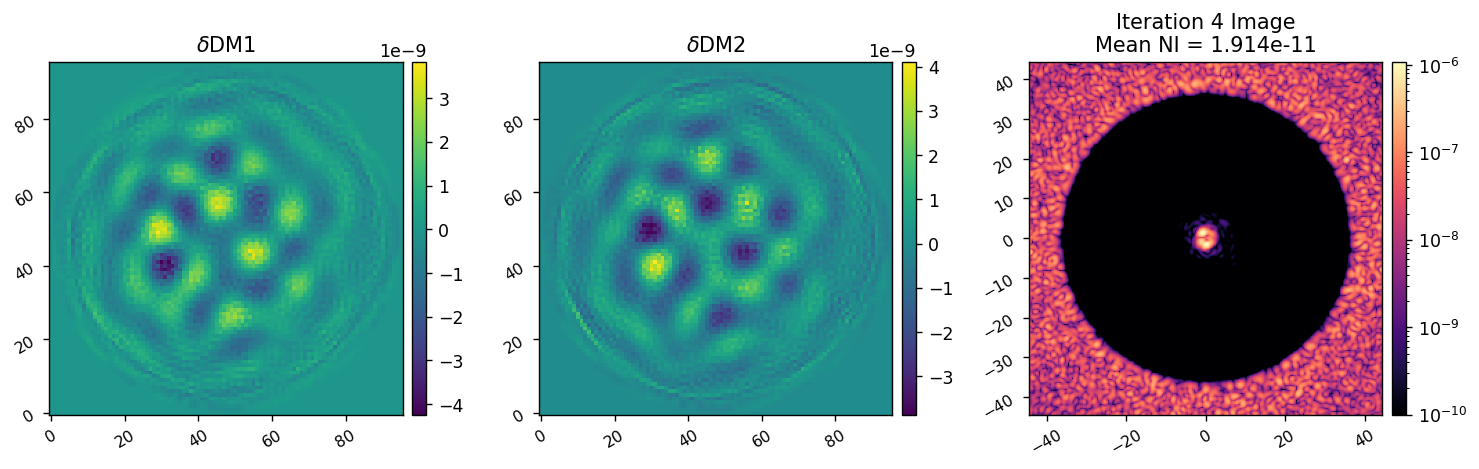

Computing E-field with model ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14736     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.16863D+07


 This problem is unconstrained.



At iterate    1    f=  8.55081D-01    |proj g|=  7.82227D+06

At iterate    2    f=  6.81818D-01    |proj g|=  2.33863D+06

At iterate    3    f=  6.45540D-01    |proj g|=  2.02738D+06

At iterate    4    f=  5.94267D-01    |proj g|=  1.53019D+06

At iterate    5    f=  5.87075D-01    |proj g|=  3.56338D+06

At iterate    6    f=  5.59052D-01    |proj g|=  1.14752D+06

At iterate    7    f=  5.47659D-01    |proj g|=  8.53394D+05

At iterate    8    f=  5.34956D-01    |proj g|=  9.04531D+05

At iterate    9    f=  5.23884D-01    |proj g|=  9.85444D+05

At iterate   10    f=  5.22682D-01    |proj g|=  7.93167D+05

At iterate   11    f=  5.16791D-01    |proj g|=  5.16136D+05

At iterate   12    f=  5.13594D-01    |proj g|=  5.82665D+05

At iterate   13    f=  5.06149D-01    |proj g|=  1.11574D+06

At iterate   14    f=  5.03507D-01    |proj g|=  1.44871D+06

At iterate   15    f=  4.98685D-01    |proj g|=  4.80600D+05

At iterate   16    f=  4.96162D-01    |proj g|=  3.52170D+05

At iter

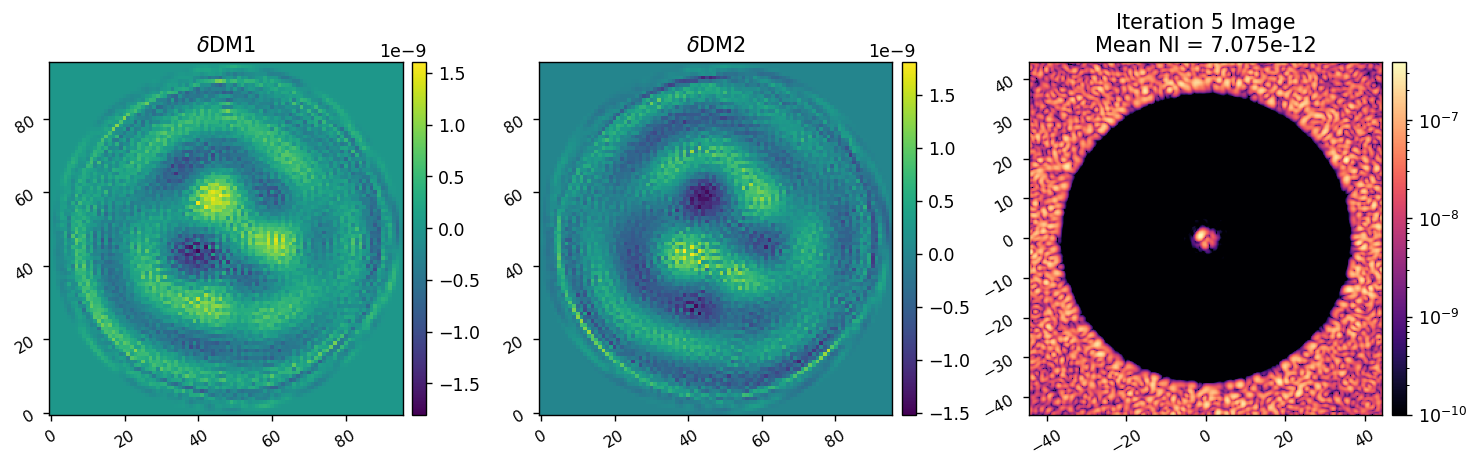

Computing E-field with model ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14736     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.47778D+07


 This problem is unconstrained.



At iterate    1    f=  7.27121D-01    |proj g|=  1.02906D+07

At iterate    2    f=  5.18993D-01    |proj g|=  4.90762D+06

At iterate    3    f=  4.47600D-01    |proj g|=  3.74199D+06

At iterate    4    f=  4.03446D-01    |proj g|=  4.10665D+06

At iterate    5    f=  3.70131D-01    |proj g|=  2.98052D+06

At iterate    6    f=  3.50812D-01    |proj g|=  2.73237D+06

At iterate    7    f=  3.20657D-01    |proj g|=  2.12263D+06

At iterate    8    f=  3.16588D-01    |proj g|=  2.04368D+06

At iterate    9    f=  2.96004D-01    |proj g|=  1.66716D+06

At iterate   10    f=  2.85913D-01    |proj g|=  1.27893D+06

At iterate   11    f=  2.80109D-01    |proj g|=  2.99175D+06

At iterate   12    f=  2.72495D-01    |proj g|=  1.11645D+06

At iterate   13    f=  2.69400D-01    |proj g|=  1.00194D+06

At iterate   14    f=  2.63145D-01    |proj g|=  1.12351D+06

At iterate   15    f=  2.59529D-01    |proj g|=  1.74888D+06

At iterate   16    f=  2.54696D-01    |proj g|=  8.61072D+05

At iter

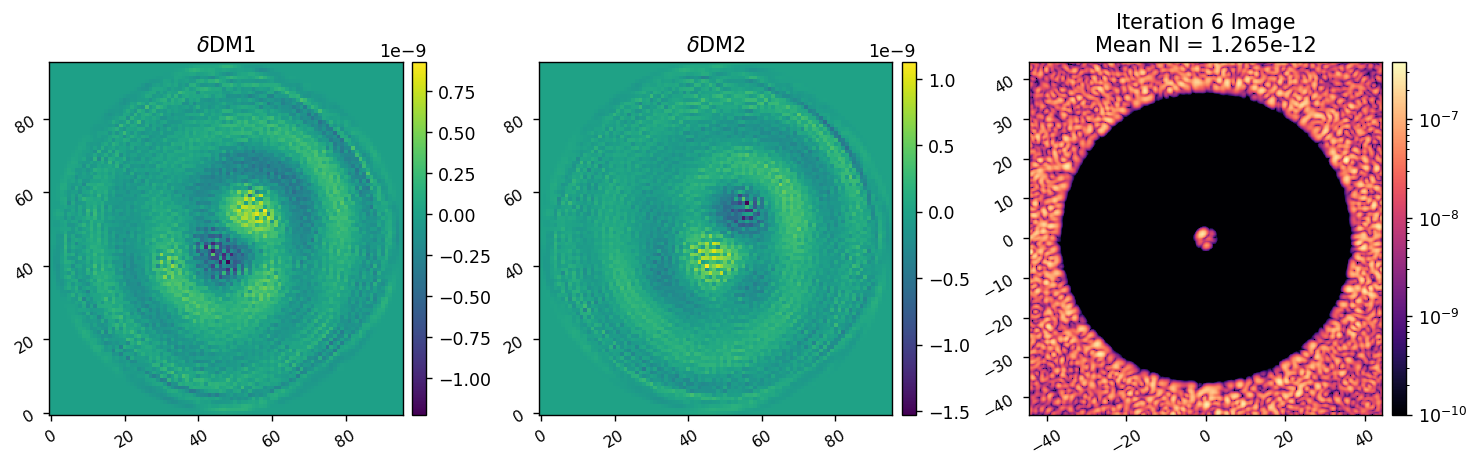

In [15]:
reload(fraunhofer)
reload(aefc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':1,
    'maxiter':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = aefc.run(
    I, 
    M, 
    fraunhofer.val_and_grad, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)

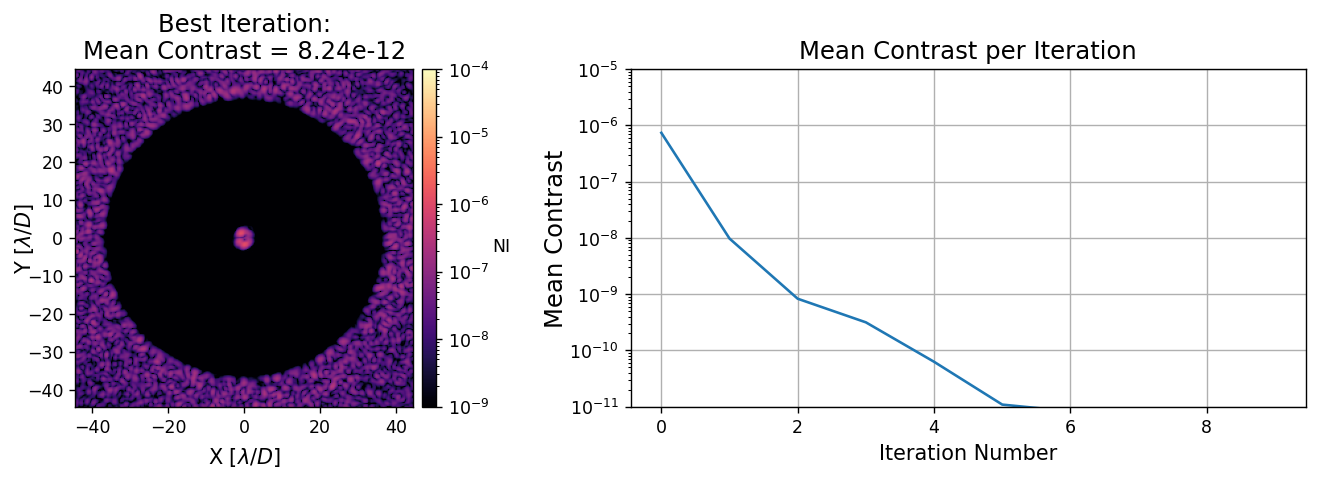

In [ ]:
plot_data(data, vmin=1e-11, vmax=1e-5)

In [28]:
Nwaves = 9
wavelength_c = 650e-9
bw = 0.02
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

I.bandpasses = bandpasses

[[6.43500e-07 6.45125e-07 6.46750e-07]
 [6.48375e-07 6.50000e-07 6.51625e-07]
 [6.53250e-07 6.54875e-07 6.56500e-07]]


In [29]:
bbim = I.snap()

1.219955124448554e-10


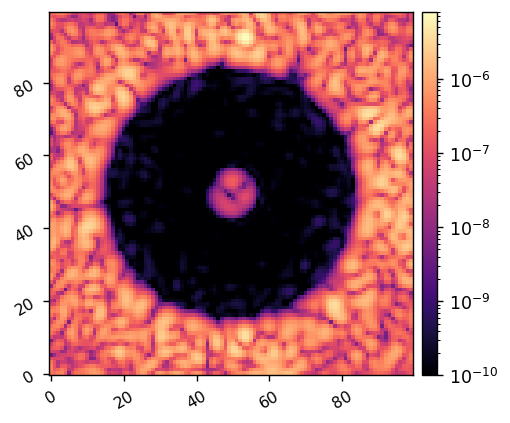

In [30]:
print(xp.mean(bbim[control_mask]))
imshow1(bbim, lognorm=True, vmin=1e-10)

2.957104218666926e-09


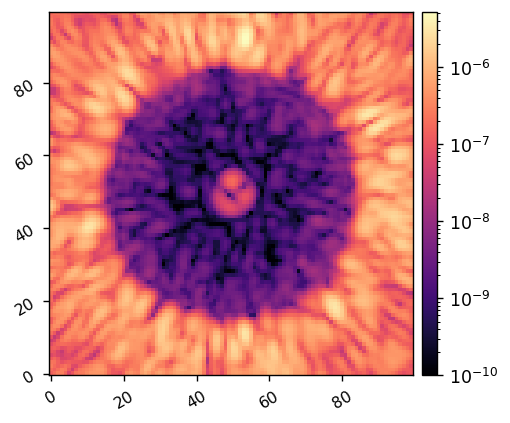

In [27]:
print(xp.mean(bbim[control_mask]))
imshow1(bbim, lognorm=True, vmin=1e-10)